Your goal is to implement the following idea:{title}. The proposed experiment is as follows:{Experiment}. 请你按照这个想法和实验，设计新的代码。

    {
        "Name": "递进式预测链",
        "Thought": "长期预测面临的最大挑战是误差累积。传统的端到端预测方法容易在长期预测中产生显著偏差。通过将预测过程分解为多个短期预测链，并在每个预测步骤引入误差修正，可以显著降低误差累积。这类似于数值计算中的误差控制思想，通过分步求解提高整体精度。",
        "Title": "基于误差反馈的递进式中长期预测框架",
        "Experiment": "设计递进式预测机制：(1)将7-30天的预测分解为多个连续的预测链；(2)在每个预测步骤引入误差修正机制；(3)设计误差累积抑制策略；(4)实现预测链的动态调整；(5)对比不同预测链长度的效果。",
        "Interestingness": 9,
        "Feasibility": 8,
        "Novelty": 8
    },

/tmp/ipykernel_1179/2867204155.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'density_growth_{days}d_smooth'] = df[f'density_growth_{days}d'].rolling(
/tmp/ipykernel_1179/2867204155.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'density_growth_{days}d_adjusted'] = df[f'density_growth_{days}d_smooth'] * adjustment_factor
/tmp/ipykernel_1179/2867204155.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

数据集总长度: 1064 天
数据集起始日期: 2021-01-01 00:00:00
数据集结束日期: 2024-05-31 00:00:00
训练集起始日期: 2021-01-01 00:00:00
训练集结束日期: 2024-01-31 00:00:00
测试集起始日期: 2023-11-01 00:00:00
测试集结束日期: 2024-05-31 00:00:00
第一个可用于训练的日期: 2021-03-02 00:00:00
可用于训练的天数: 883 天

训练预测链 1-7 天
Epoch [30/150], Average Loss: 0.0087
Epoch [60/150], Average Loss: 0.0086
Epoch [90/150], Average Loss: 0.0086
Epoch [120/150], Average Loss: 0.0086
Epoch [150/150], Average Loss: 0.0085

预测链 1-7 天的预测结果:

训练预测链 8-14 天
Epoch [30/150], Average Loss: 0.0083
Epoch [60/150], Average Loss: 0.0081
Epoch [90/150], Average Loss: 0.0080
Epoch [120/150], Average Loss: 0.0080
Epoch [150/150], Average Loss: 0.0079

预测链 1-7 天的预测结果:

预测链 8-14 天的预测结果:

训练预测链 15-21 天
Epoch [30/150], Average Loss: 0.0066
Epoch [60/150], Average Loss: 0.0065
Epoch [90/150], Average Loss: 0.0067
Epoch [120/150], Average Loss: 0.0065
Epoch [150/150], Average Loss: 0.0064

预测链 1-7 天的预测结果:

预测链 8-14 天的预测结果:

预测链 15-21 天的预测结果:

训练预测链 22-30 天
Epoch [30/150], Average Loss: 0.0047
E

ValueError: num must be an integer with 1 <= num <= 28, not 29

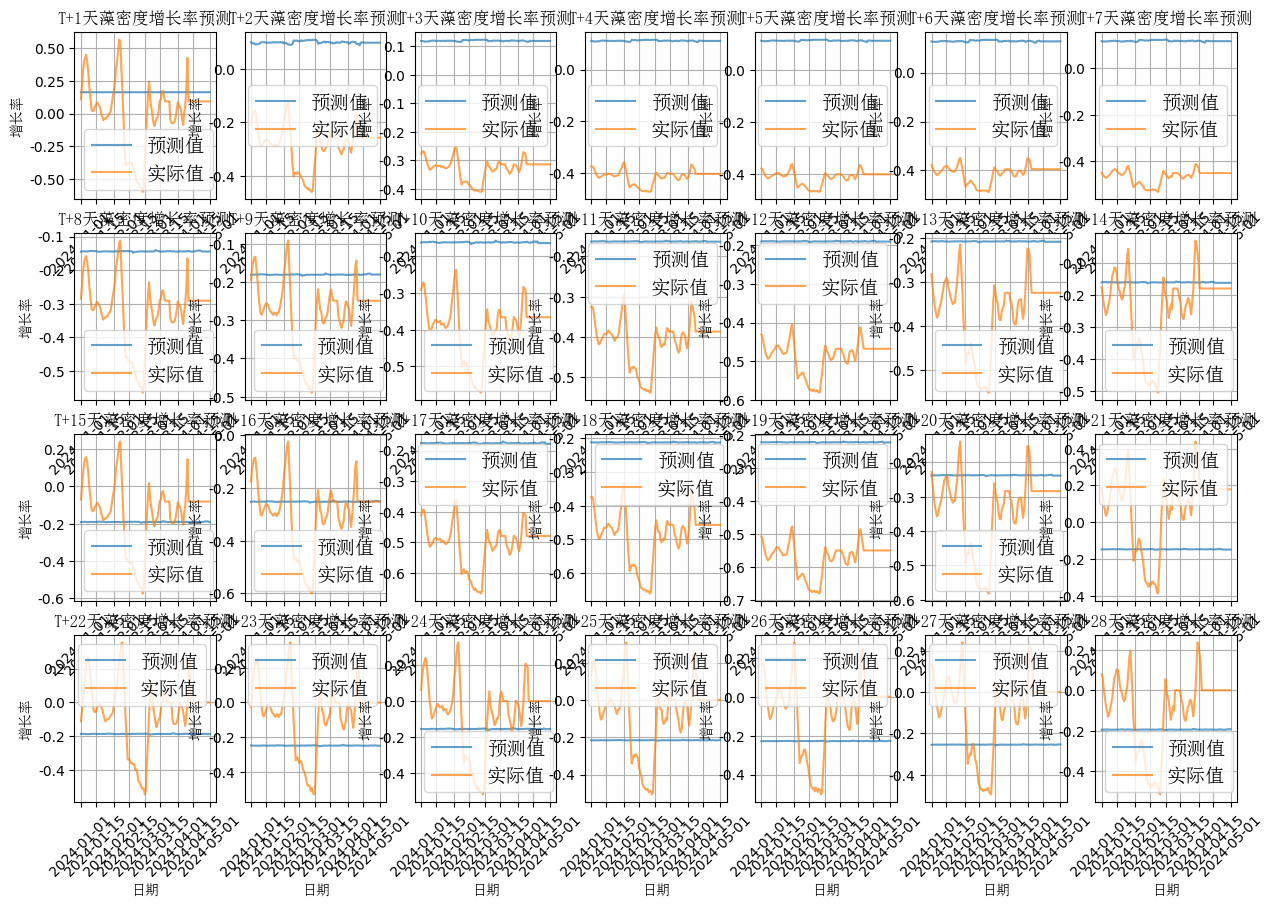

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 剔除6-7月的数据
df = df[~df.index.month.isin([6, 7])]

# 实现递进式预测链,将7-30天预测分解为多个连续预测链
prediction_chains = [(1,7), (8,14), (15,21), (22,30)]  # 将预测分为4个链

for start_day, end_day in prediction_chains:
    # 计算每个预测链的增长率
    for days in range(start_day, end_day + 1):
        # 基础增长率计算
        df[f'density_growth_{days}d'] = (df['density'].shift(-days) - df['density']) / df['density']
        
        # 误差修正机制
        if days > 1:
            # 基于前一天预测的误差进行修正
            df[f'error_{days}d'] = df[f'density_growth_{days-1}d'].shift(1) - df[f'density_growth_{days-1}d']
            # 使用指数平滑计算累积误差
            df[f'cumulative_error_{days}d'] = df[f'error_{days}d'].ewm(span=5).mean()
            
        # 误差累积抑制
        window_size = min(5, days)  # 动态调整窗口大小
        df[f'density_growth_{days}d_smooth'] = df[f'density_growth_{days}d'].rolling(
            window=window_size, center=True).mean()
        
        # 添加动态调整因子
        if days > 1:
            adjustment_factor = 1.0 / (1.0 + np.abs(df[f'cumulative_error_{days}d']))
            df[f'density_growth_{days}d_adjusted'] = df[f'density_growth_{days}d_smooth'] * adjustment_factor

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        # 针对不同预测链使用不同的网络结构
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(hidden_size, 4)  # 添加注意力机制
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 应用注意力机制
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc(attn_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列,支持递进式预测"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 基础特征
base_features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                'turbidity', 'chla', 'density', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                'strong_wind']

# 为每个预测链创建独立模型
chain_models = {}
chain_predictions = {}
chain_actuals = {}

# 使用固定日期划分训练集和测试集
train_start_date = '2021-01-01'
train_end_date = '2024-01-31'
test_start_date = '2023-11-01'
test_end_date = '2024-05-31'

# 数据集检查
print(f"数据集总长度: {len(df)} 天")
print(f"数据集起始日期: {df.index[0]}")
print(f"数据集结束日期: {df.index[-1]}")

# 获取训练集和测试集的索引
train_mask = (df.index >= train_start_date) & (df.index <= train_end_date)
test_mask = (df.index >= test_start_date) & (df.index <= test_end_date)
train_size = sum(train_mask)

print(f"训练集起始日期: {df.index[train_mask][0]}")
print(f"训练集结束日期: {df.index[train_mask][-1]}")
print(f"测试集起始日期: {df.index[test_mask][0]}")
print(f"测试集结束日期: {df.index[test_mask][-1]}")

seq_length = 60
first_valid_date = df.index[seq_length]
print(f"第一个可用于训练的日期: {first_valid_date}")
print(f"可用于训练的天数: {train_size - seq_length} 天")

# 训练每个预测链的模型
for start_day, end_day in prediction_chains:
    print(f"\n训练预测链 {start_day}-{end_day} 天")
    
    chain_features = base_features.copy()
    # 添加该预测链的特征
    for days in range(start_day, end_day + 1):
        chain_features.extend([
            f'density_growth_{days}d',
            f'density_growth_{days}d_smooth'
        ])
        if days > 1:
            chain_features.extend([
                f'error_{days}d',
                f'cumulative_error_{days}d',
                f'density_growth_{days}d_adjusted'
            ])
    
    data = df[chain_features].values
    data = np.nan_to_num(data, nan=0)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    train_data = scaled_data[train_mask]
    test_data = scaled_data[test_mask]
    
    # 构建训练序列
    train_sequences = []
    train_targets = []
    
    for i in range(seq_length, len(train_data)):
        seq = create_sequence_for_date(scaled_data, i, seq_length)
        if seq is not None:
            train_sequences.append(seq)
            # 使用调整后的增长率作为目标
            target_indices = [chain_features.index(f'density_growth_{days}d_adjusted') 
                            if days > 1 else chain_features.index(f'density_growth_{days}d_smooth')
                            for days in range(start_day, end_day + 1)]
            train_targets.append(train_data[i, target_indices])
    
    X_train = torch.FloatTensor(train_sequences)
    y_train = torch.FloatTensor(train_targets)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 初始化该预测链的模型
    model = LSTMModel(
        input_size=len(chain_features),
        hidden_size=128,  # 增加隐藏层大小以处理更复杂的关系
        num_layers=3,     # 增加层数以提高模型容量
        output_size=end_day - start_day + 1
    )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=150, steps_per_epoch=len(train_loader))
    
    # 训练模型
    epochs = 150
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 30 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')
    
    chain_models[(start_day, end_day)] = (model, scaler, chain_features)
        # 预测阶段
    model.eval()
    predictions_all = {}
    actual_values_all = {}
    
    # 对每个预测链进行预测
    for (start_day, end_day), (model, scaler, chain_features) in chain_models.items():
        print(f"\n预测链 {start_day}-{end_day} 天的预测结果:")
        
        predictions = []
        actual_values = []
        
        # 确保输入序列特征数量与模型输入大小一致
        current_sequence = scaled_data[test_mask][0:seq_length, :len(chain_features)]
        
        with torch.no_grad():
            for i in range(len(test_data) - end_day):
                current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
                pred = model(current_sequence_tensor)
                
                # 存储每个天数的预测结果
                for idx, days in enumerate(range(start_day, end_day + 1)):
                    if days not in predictions_all:
                        predictions_all[days] = []
                        actual_values_all[days] = []
                    
                    # 获取对应天数的预测值和实际值
                    target_idx = chain_features.index(f'density_growth_{days}d_adjusted') if days > 1 else chain_features.index(f'density_growth_{days}d_smooth')
                    
                    # 应用误差修正
                    prediction = pred[0, idx].item()
                    if days > 1 and i > 0:
                        error_idx = chain_features.index(f'cumulative_error_{days}d')
                        error_correction = test_data[i, error_idx]
                        prediction = prediction * (1.0 / (1.0 + abs(error_correction)))
                    
                    predictions_all[days].append(prediction)
                    actual_values_all[days].append(test_data[i+days, target_idx])
                
                # 动态更新序列,确保特征数量一致
                next_sequence = test_data[i][:len(chain_features)]
                current_sequence = np.vstack([
                    current_sequence[1:],
                    next_sequence
                ])
        
        # 反归一化预测结果
        for days in range(start_day, end_day + 1):
            pred_full_features = np.zeros((len(predictions_all[days]), len(chain_features)))
            actual_full_features = np.zeros((len(actual_values_all[days]), len(chain_features)))
            
            target_idx = chain_features.index(f'density_growth_{days}d_adjusted') if days > 1 else chain_features.index(f'density_growth_{days}d_smooth')
            pred_full_features[:, target_idx] = np.array(predictions_all[days])
            actual_full_features[:, target_idx] = np.array(actual_values_all[days])
            
            predictions_all[days] = scaler.inverse_transform(pred_full_features)[:, target_idx]
            actual_values_all[days] = scaler.inverse_transform(actual_full_features)[:, target_idx]

# 计算每个预测链的RMSE
for start_day, end_day in prediction_chains:
    print(f"\n预测链 {start_day}-{end_day} 天的RMSE:")
    for days in range(start_day, end_day + 1):
        rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
        print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 绘制2024年1-5月的预测结果
plt.figure(figsize=(15, 10))
start_date = '2024-01-01'
end_date = '2024-05-31'

# 获取测试集日期
test_dates = df.index[test_mask]

# 确保预测日期和预测值长度一致
prediction_dates = test_dates[:-30]  # 调整日期范围以适应最长的预测期
predictions_length = len(predictions_all[1])  # 使用第一天预测作为参考长度
prediction_dates = prediction_dates[-predictions_length:]  # 截取对应长度的日期

mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 为每个预测链创建子图
for chain_idx, (start_day, end_day) in enumerate(prediction_chains):
    for days in range(start_day, end_day + 1):
        plt.subplot(len(prediction_chains), 7, chain_idx * 7 + (days - start_day + 1))
        plt.plot(pd.to_datetime(prediction_dates)[mask], predictions_all[days][-len(prediction_dates):][mask], 
                 label='预测值', alpha=0.7)
        plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values_all[days][-len(prediction_dates):][mask], 
                 label='实际值', alpha=0.7)
        
        plt.title(f'T+{days}天藻密度增长率预测', fontproperties=chinese_font, fontsize=12)
        plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
        plt.ylabel('增长率', fontproperties=chinese_font, fontsize=10)
        plt.legend(prop=chinese_font)
        plt.grid(True)
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 计算每个预测链的增长率RMSE
print("增长率预测的RMSE:")
for start_day, end_day in prediction_chains:
    print(f"\n预测链 {start_day}-{end_day} 天:")
    for days in range(start_day, end_day + 1):
        rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
        print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 基于增长率计算2024年每一天未来30天的藻密度
density_predictions = {}  # 存储每个预测链的密度预测
density_actuals = {}     # 存储每个预测链的实际密度

# 获取密度特征的索引
density_idx = base_features.index('density')

# 获取2024年的日期范围
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# 对2024年的每一天进行预测
for current_date in dates_2024:
    date_idx = np.where(pd.to_datetime(test_dates) == current_date)[0]
    
    if len(date_idx) > 0:
        idx = date_idx[0]
        if idx < len(test_data) and idx < len(predictions_all[1]) - 30:
            current_density = test_data[idx][density_idx]
            
            if current_date not in density_predictions:
                density_predictions[current_date] = {}
                density_actuals[current_date] = {}
            
            # 按预测链计算藻密度
            for start_day, end_day in prediction_chains:
                # 初始化该预测链的累积误差
                chain_error = 0
                
                # 获取该预测链的误差修正因子
                for days in range(start_day, end_day + 1):
                    # 误差修正
                    error_correction = 1.0
                    if days > 1:
                        # 使用指数衰减的累积误差进行修正
                        error_idx = chain_features.index(f'cumulative_error_{days}d')
                        error = test_data[idx][error_idx]
                        chain_error = 0.9 * chain_error + 0.1 * error  # 指数衰减
                        error_correction = 1.0 / (1.0 + abs(chain_error))
                    
                    # 应用误差修正和动态调整的增长率预测
                    if idx + days <= len(predictions_all[days]):
                        # 获取调整后的增长率预测
                        if days > 1:
                            growth_idx = chain_features.index(f'density_growth_{days}d_adjusted')
                        else:
                            growth_idx = chain_features.index(f'density_growth_{days}d_smooth')
                            
                        predicted_growth = predictions_all[days][idx] * error_correction
                        actual_growth = actual_values_all[days][idx]
                        
                        # 使用动态窗口的指数平滑抑制误差累积
                        if days > 1:
                            # 动态调整平滑因子和窗口大小
                            window_size = min(5, days)  # 动态窗口大小
                            alpha = 0.8 / (1 + abs(chain_error))  # 误差越大,平滑度越高
                            
                            # 获取前window_size天的预测结果
                            prev_densities = [density_predictions[current_date].get(d, current_density) 
                                            for d in range(max(1, days-window_size), days)]
                            
                            # 使用动态窗口的加权平均
                            weights = np.exp([-0.2 * i for i in range(len(prev_densities))])
                            weights = weights / sum(weights)
                            smoothed_density = sum(d * w for d, w in zip(prev_densities, weights))
                            
                            predicted_density = alpha * (current_density * (1 + predicted_growth)) + \
                                             (1 - alpha) * smoothed_density
                        else:
                            predicted_density = current_density * (1 + predicted_growth)
                            
                        density_predictions[current_date][days] = predicted_density
                        density_actuals[current_date][days] = current_density * (1 + actual_growth)


In [ ]:
# 按预测链分组计算RMSE和误差累积情况
print("\n2024年藻密度预测的RMSE和误差累积分析:")
for start_day, end_day in prediction_chains:
    print(f"\n预测链 {start_day}-{end_day} 天:")
    chain_errors = []  # 记录该预测链的累积误差
    chain_corrections = []  # 记录误差修正效果
    
    for days in range(start_day, end_day + 1):
        predictions = []
        actuals = []
        daily_errors = []  # 记录每天的预测误差
        correction_effects = []  # 记录误差修正的效果
        
        for date in density_predictions.keys():
            if days in density_predictions[date] and days in density_actuals[date]:
                pred = density_predictions[date][days]
                actual = density_actuals[date][days]
                predictions.append(pred)
                actuals.append(actual)
                
                # 计算相对误差和误差修正效果
                relative_error = abs((pred - actual) / actual)
                daily_errors.append(relative_error)
                
                # 计算误差修正效果
                if days > 1:
                    prev_error = chain_errors[-1] if chain_errors else 0
                    correction_effect = 1 - (relative_error / (prev_error + 1e-6))
                    correction_effects.append(correction_effect)
        
        if predictions and actuals:
            density_rmse = np.sqrt(mean_squared_error(actuals, predictions))
            avg_error = np.mean(daily_errors)
            chain_errors.append(avg_error)
            
            # 分析误差修正效果
            if correction_effects:
                avg_correction = np.mean(correction_effects)
                chain_corrections.append(avg_correction)
                correction_status = "有效" if avg_correction > 0 else "需优化"
            else:
                correction_status = "基准预测"
            
            # 显示详细分析结果
            cumulative_error = np.mean(chain_errors)
            print(f"T+{days}天预测分析:")
            print(f"  - RMSE: {density_rmse:.4f}")
            print(f"  - 当前相对误差: {avg_error:.4f}")
            print(f"  - 累积误差: {cumulative_error:.4f}")
            print(f"  - 误差修正状态: {correction_status}")

# 绘制2024年1-5月的预测结果和误差分析
start_date = '2024-01-01'
end_date = '2024-05-31'
prediction_dates = [date for date in density_predictions.keys() 
                   if pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date)]

# 按预测链分组可视化分析
for chain_idx, (start_day, end_day) in enumerate(prediction_chains):
    plt.figure(figsize=(8, 10))
    days_in_chain = end_day - start_day + 1
    rows = (days_in_chain + 1) // 2
    
    # 分析该预测链的误差趋势
    chain_metrics = []
    for days in range(start_day, end_day + 1):
        valid_pred = []
        valid_actual = []
        for date in prediction_dates:
            if days in density_predictions[date] and days in density_actuals[date]:
                valid_pred.append(density_predictions[date][days])
                valid_actual.append(density_actuals[date][days])
        if valid_pred:
            rmse = np.sqrt(mean_squared_error(valid_actual, valid_pred))
            rel_error = np.mean([abs((p-a)/a) for p,a in zip(valid_pred, valid_actual)])
            chain_metrics.append({'rmse': rmse, 'rel_error': rel_error})
    
    for i, days in enumerate(range(start_day, end_day + 1)):
        plt.subplot(rows, 2, i+1)
        
        valid_dates = []
        pred_values = []
        actual_values = []
        
        for date in prediction_dates:
            if days in density_predictions[date] and days in density_actuals[date]:
                valid_dates.append(date)
                pred_values.append(density_predictions[date][days])
                actual_values.append(density_actuals[date][days])
        
        if valid_dates:
            plt.plot(valid_dates, pred_values, label='预测密度', alpha=0.7)
            plt.plot(valid_dates, actual_values, label='实际密度', alpha=0.7)
            
            # 添加误差分析信息
            metrics = chain_metrics[i]
            error_trend = "↑" if i > 0 and metrics['rmse'] > chain_metrics[i-1]['rmse'] else "↓"
            plt.title(f'T+{days}天预测\nRMSE: {metrics["rmse"]:.2f} {error_trend}\n相对误差: {metrics["rel_error"]:.2f}', 
                     fontproperties=chinese_font, fontsize=10)
            
            plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
            plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
            plt.legend(prop=chinese_font)
            plt.grid(True)
            plt.xticks(rotation=45)
            
            ax = plt.gca()
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontproperties(english_font)
    
    avg_metrics = {
        'rmse': np.mean([m['rmse'] for m in chain_metrics]),
        'rel_error': np.mean([m['rel_error'] for m in chain_metrics])
    }
    plt.suptitle(f'预测链 {start_day}-{end_day}天 分析结果\n'
                 f'平均RMSE: {avg_metrics["rmse"]:.4f} | 平均相对误差: {avg_metrics["rel_error"]:.4f}', 
                 fontproperties=chinese_font, fontsize=12)
    plt.tight_layout()
    plt.show()

# # 单独绘制所有天数的藻密度预测结果对比
# plt.figure(figsize=(8, 10))

# # 对每个预测天数
# for days in range(1, 31):
#     valid_dates = []
#     pred_values = []
    
#     for date in prediction_dates:
#         if days in density_predictions[date]:
#             valid_dates.append(date)
#             pred_values.append(density_predictions[date][days])
    
#     if valid_dates:  # 只在有有效数据时绘图
#         plt.plot(valid_dates, pred_values, label=f'T+{days}天预测', alpha=0.7)

# # 绘制实际值
# valid_dates = []
# actual_values = []
# for date in prediction_dates:
#     if 1 in density_actuals[date]:  # 使用T+1天的实际值
#         valid_dates.append(date)
#         actual_values.append(density_actuals[date][1])

# if valid_dates:
#     plt.plot(valid_dates, actual_values, label='实际密度', color='black', linewidth=2)

# plt.title('未来30天藻密度预测对比', fontproperties=chinese_font, fontsize=12)
# plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
# plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
# plt.legend(prop=chinese_font, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.xticks(rotation=45)

# # 设置刻度字体为英文字体
# ax = plt.gca()
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontproperties(english_font)

# plt.tight_layout()
# plt.show()
